In [1]:
# import tensorflow as tf
# sess = tf.Session()
import keras
from keras import backend as K
# K.set_session(sess)


from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, GRU, Masking, Dropout, Lambda, Flatten, concatenate, Conv1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences

from keras.backend import ctc_batch_cost, ctc_decode
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import pandas 

from process_data import *
import os



Using TensorFlow backend.


ImportError: No module named python_speech_features

In [2]:
import h5py

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16981882811739105125
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 264634368
locality {
  bus_id: 1
}
incarnation: 4315876161457734053
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [ ]:
batch_folder_name = "converted_data_libri"
reg_expr = r"^(libri.*)\.id"
stem_names = get_names(batch_folder_name, reg_expr)
abs_names = [os.path.join(batch_folder_name, x) for x in stem_names]
sample_mfes = []
sample_phonemes = []
sample_ids = []
for (i, batch_name) in enumerate(abs_names):
    (ids_batch, mfe_batch, phoneme_batch) = load_batch(batch_name)
    sample_mfes.extend(mfe_batch)
    sample_phonemes.extend(phoneme_batch)
    sample_ids.extend(ids_batch)

In [4]:
print len(sample_mfes), len(sample_phonemes)

 65249 65249


In [44]:
sample_phonemes[0]

[u'N',
 u'AA',
 u'T',
 ' ',
 u'K',
 u'AH',
 u'M',
 u'P',
 u'AE',
 u'T',
 u'AH',
 u'B',
 u'AH',
 u'L',
 ' ',
 u'W',
 u'IH',
 u'DH',
 ' ',
 u'IH',
 u'N',
 u'D',
 u'IH',
 u'V',
 u'IH',
 u'JH',
 u'UW',
 u'AE',
 u'L',
 u'IH',
 u'T',
 u'IY',
 ' ',
 u'AY',
 ' ',
 u'AE',
 u'M',
 ' ',
 u'AH',
 u'V',
 ' ',
 u'K',
 u'AO',
 u'R',
 u'S',
 ' ',
 u'N',
 u'AA',
 u'T',
 ' ',
 u'AH',
 u'N',
 u'D',
 u'ER',
 u'T',
 u'EY',
 u'K',
 u'IH',
 u'NG',
 ' ',
 u'HH',
 u'IY',
 u'R',
 ' ',
 u'T',
 u'UW',
 ' ',
 u'D',
 u'IH',
 u'S',
 u'K',
 u'AH',
 u'S',
 ' ',
 u'DH',
 u'AH',
 ' ',
 u'M',
 u'EH',
 u'R',
 u'AH',
 u'T',
 u'S',
 ' ',
 u'AH',
 u'V',
 ' ',
 u'S',
 u'OW',
 u'SH',
 u'AH',
 u'L',
 u'IH',
 u'Z',
 u'AH',
 u'M',
 ' ',
 u'M',
 u'AY',
 ' ',
 u'P',
 u'ER',
 u'P',
 u'AH',
 u'S',
 ' ',
 u'IH',
 u'Z',
 ' ',
 u'OW',
 u'N',
 u'L',
 u'IY',
 ' ',
 u'T',
 u'UW',
 ' ',
 u'P',
 u'OY',
 u'N',
 u'T',
 ' ',
 u'AW',
 u'T',
 ' ',
 u'DH',
 u'AE',
 u'T',
 ' ',
 u'DH',
 u'OW',
 u'Z',
 ' ',
 u'HH',
 u'UW',
 ' ',
 u'AA',
 u'R',
 ' ',

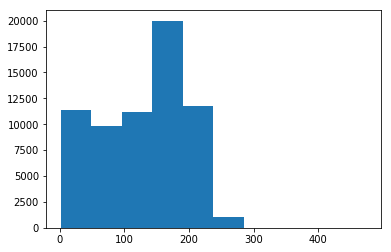

In [12]:
plt.hist(map(lambda x: len(x), sample_phonemes));

In [4]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
#     y_pred = y_pred[:, 2:, :]
    return ctc_batch_cost(labels, y_pred, input_length, label_length)

In [5]:
stack_size = 1
n_hidden_layers = 3
n_filters = 32
kernel_size = 3
residuals = True
dilation_reset = 7
rf_size  = 3**(min(dilation_reset-1, n_hidden_layers+1))
print "rf_size =", rf_size*10, "ms"
max_mfe_len = 1800
max_phrase_len = 250
n_energies = 40 * stack_size
n_phonemes = 40+1
blank_idx = n_phonemes - 1
labels = Input(name='the_labels', shape=[max_phrase_len], dtype='float32')
labels_masked = Masking()(labels)
input_length = Input(name='input_length',shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
log_mfes = Input(shape=(max_mfe_len, n_energies), name="log_mfes")
masked = log_mfes
layers = [masked]
accums = [masked]
for i in range( n_hidden_layers):
    
    if residuals and i >0:
        print len(layers)
        accums.append(keras.layers.concatenate([accums[-1], layers[-1]]))
        linear = Conv1D(n_filters, kernel_size, padding='same', dilation_rate=3**(i%dilation_reset), activation="linear")(accums[-1])
    else:
        linear = Conv1D(n_filters, kernel_size, padding='same', dilation_rate=3**(i%dilation_reset), activation="linear")(layers[-1])
    batch_normed = BatchNormalization(layer)
    activated = Activation("relu")
    layers.append(activated)

if residuals:
    
    all_concat = keras.layers.concatenate([accums[-1], layers[-1]])
    phoneme_probs = Conv1D(n_phonemes, kernel_size, padding='same', dilation_rate=3**(n_hidden_layers%dilation_reset), activation='softmax', name="phoneme_probs")(BatchNormalization()(all_concat))
else:
    phoneme_probs = Conv1D(n_phonemes, kernel_size, padding='same', dilation_rate=3**(n_hidden_layers%dilation_reset), activation='softmax', name="phoneme_probs")(BatchNormalization()(layers[-1]))

# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([phoneme_probs, labels_masked, input_length, label_length])
# reshaped_input_lengths = Reshape((-1,))(input_length)
# decoded = Lambda(ctc_decode, output_shape=(None,1))([phoneme_probs,  input_length_flat])

model = Model(inputs=[log_mfes, labels, input_length, label_length], outputs=[loss_out, phoneme_probs])

model.summary()

rf_size = 810 ms
2
3
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
log_mfes (InputLayer)            (None, 1800, 40)      0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 1800, 40)      160         log_mfes[0][0]                   
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 1800, 32)      3872        batch_normalization_1[0][0]      
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 1800, 72)      0           log_mfes[0][0]                   
                                                                   con

In [15]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [6]:
# clipnorm seems to speeds up convergence
sgd = Adam(lr=0.02, clipnorm=5)


# the loss calc occurs elsewhere, so use a dummy lambda func for the loss (y_pred is actually loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred, 'phoneme_probs': lambda y_true, y_pred: 0*y_pred}, optimizer=sgd)

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
short_indices = [i for (i,mfe) in enumerate(sample_mfes) if mfe.shape[0] <= max_mfe_len and len(sample_phonemes[i])<=max_phrase_len]
short_mfes = [sample_mfes[i] for i in short_indices]
short_phonemes =[sample_phonemes[i] for i in short_indices]
short_ids = [sample_ids[i] for i in short_indices]
len(short_phonemes)

64842

In [16]:
temp_mfes = short_mfes[:30000]
temp_phonemes = short_phonemes[:30000]
short_mfes = temp_mfes
short_phonemes = temp_phonemes
del temp_mfes
del temp_phonemes



In [17]:
len(short_mfes)

30000

(array([  1351.,   3270.,   3141.,   2979.,   2947.,   3550.,   6297.,
         13894.,  22122.,   5291.]),
 array([  105. ,   268.9,   432.8,   596.7,   760.6,   924.5,  1088.4,
         1252.3,  1416.2,  1580.1,  1744. ]),
 <a list of 10 Patch objects>)

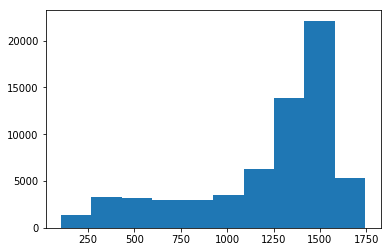

In [19]:
plt.hist(map(lambda x: x.shape[0], short_mfes))

In [18]:
input_lengths = [x.shape[0] for x in short_mfes]
label_lengths = [len(x) for x in short_phonemes]
phoneme_idxs  = [code_phonemes(x) for x in short_phonemes]
print "Created data, plotting histogram..."


Created data, plotting histogram...


In [19]:
len(phoneme_idxs)

30000

In [ ]:
all_idxs = [idx for phrase in phoneme_idxs for idx in phrase]

plt.hist(all_idxs,bins=len(set(all_idxs)));

In [20]:
from keras.preprocessing.sequence import pad_sequences

# Should I pad at the beginning or the end? Probably the end
# Pad with value 69 because the phonemes are indexed 0 to 68
y = keras.preprocessing.sequence.pad_sequences(phoneme_idxs, maxlen=max_phrase_len, dtype='int32',
    padding='post', truncating='post', value=-1)
y.shape

(30000, 250)

In [21]:
y[0]

array([23,  1, 31,  0, 20,  3, 22, 27,  2, 31,  3,  7,  3, 21,  0, 36, 17,
       10,  0, 17, 23,  9, 17, 35, 17, 19, 34,  2, 21, 17, 31, 18,  0,  6,
        0,  2, 22,  0,  3, 35,  0, 20,  4, 28, 29,  0, 23,  1, 31,  0,  3,
       23,  9, 12, 31, 13, 20, 17, 24,  0, 16, 18, 28,  0, 31, 34,  0,  9,
       17, 29, 20,  3, 29,  0, 10,  3,  0, 22, 11, 28,  3, 31, 29,  0,  3,
       35,  0, 29, 25, 30,  3, 21, 17, 38,  3, 22,  0, 22,  6,  0, 27, 12,
       27,  3, 29,  0, 17, 38,  0, 25, 23, 21, 18,  0, 31, 34,  0, 27, 26,
       23, 31,  0,  5, 31,  0, 10,  2, 31,  0, 10, 25, 38,  0, 16, 34,  0,
        1, 28,  0, 16,  1, 29, 31,  3, 21,  0, 31, 34,  0, 29, 25, 30,  3,
       21, 17, 38,  3, 22,  0, 22,  3, 29, 31,  0,  8, 11, 28, 17, 30,  0,
       21, 17,  7, 12, 31, 18,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

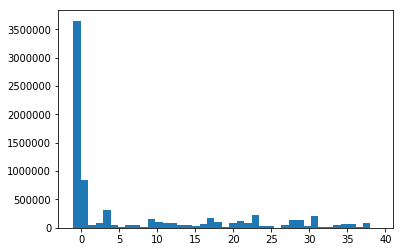

In [22]:
plt.hist(y.flatten(), bins=len(set(y.flatten())));

In [23]:
X=keras.preprocessing.sequence.pad_sequences(short_mfes, maxlen=max_mfe_len, dtype='float32',
    padding='post', truncating='post', value=0.)
X.shape

(30000, 1800, 40)

In [24]:
X[0]

array([[-25.22766495, -25.58367348, -24.97477341, ..., -19.49644661,
        -20.03422737, -20.23960686],
       [-25.35206604, -27.12319946, -24.7471714 , ..., -19.48760796,
        -19.78377151, -20.38406944],
       [-24.89183998, -25.01822853, -24.60209084, ..., -19.62212944,
        -19.67237854, -19.67811966],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]], dtype=float32)

In [26]:
inputs = {'log_mfes': X[:,:,:40],
          'the_labels': y,
          'input_length': np.asarray(input_lengths),
          'label_length': np.asarray(label_lengths),
#           'source_str': source_str  # used for visualization only
          }
outputs = {'ctc': np.zeros([len(input_lengths)]), 
           'phoneme_probs':np.zeros([len(input_lengths),n_phonemes, max_mfe_len])}  # dummy data for dummy loss function
from keras.callbacks import ModelCheckpoint
model_name = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath = "saved_models/"+model_name, monitor="val acc")

In [30]:
# callback = keras.function([log_mfes], [])
model.fit(inputs, outputs, epochs=200, validation_split = 0.2, batch_size = 32, verbose = 1)

Train on 21000 samples, validate on 9000 samples
Epoch 1/200
21000/21000 [==============================] - 1047s - loss: 402.4241 - ctc_loss: 402.4241 - phoneme_probs_loss: 0.0000e+00 - val_loss: 388.2774 - val_ctc_loss: 388.2774 - val_phoneme_probs_loss: 0.0000e+00
Epoch 2/200
21000/21000 [==============================] - 1047s - loss: 379.2786 - ctc_loss: 379.2786 - phoneme_probs_loss: 0.0000e+00 - val_loss: 367.2220 - val_ctc_loss: 367.2220 - val_phoneme_probs_loss: 0.0000e+00
Epoch 3/200
21000/21000 [==============================] - 1046s - loss: 368.6271 - ctc_loss: 368.6271 - phoneme_probs_loss: 0.0000e+00 - val_loss: 359.8072 - val_ctc_loss: 359.8072 - val_phoneme_probs_loss: 0.0000e+00
Epoch 4/200
21000/21000 [==============================] - 1046s - loss: 359.3557 - ctc_loss: 359.3557 - phoneme_probs_loss: 0.0000e+00 - val_loss: 356.8541 - val_ctc_loss: 356.8541 - val_phoneme_probs_loss: 0.0000e+00
Epoch 5/200
21000/21000 [==============================] - 1046s - loss: 35

21000/21000 [==============================] - 1042s - loss: 325.3368 - ctc_loss: 325.3368 - phoneme_probs_loss: 0.0000e+00 - val_loss: 322.4199 - val_ctc_loss: 322.4199 - val_phoneme_probs_loss: 0.0000e+00
Epoch 39/200
21000/21000 [==============================] - 1045s - loss: 325.6782 - ctc_loss: 325.6782 - phoneme_probs_loss: 0.0000e+00 - val_loss: 320.1518 - val_ctc_loss: 320.1518 - val_phoneme_probs_loss: 0.0000e+00
Epoch 40/200
21000/21000 [==============================] - 1042s - loss: 325.8123 - ctc_loss: 325.8123 - phoneme_probs_loss: 0.0000e+00 - val_loss: 323.0477 - val_ctc_loss: 323.0477 - val_phoneme_probs_loss: 0.0000e+00
Epoch 41/200
21000/21000 [==============================] - 1046s - loss: 325.3063 - ctc_loss: 325.3063 - phoneme_probs_loss: 0.0000e+00 - val_loss: 324.4142 - val_ctc_loss: 324.4142 - val_phoneme_probs_loss: 0.0000e+00
Epoch 42/200
15008/21000 [====================>.........] - ETA: 230s - loss: 325.9322 - ctc_loss: 325.9322 - phoneme_probs_loss: 0.0

KeyboardInterrupt: 

In [75]:
import keras
import h5py
model.save("saved_models/first_aws_model.h3.f32.k3.L320.1518")

ImportError: `save_model` requires h5py.

In [37]:
ctc_costs, probs = model.predict({'log_mfes': X[:100,:,:40],
          'the_labels': y[:100],
          'input_length': np.asarray(input_lengths[:100]),
          'label_length': np.asarray(label_lengths[:100])})

3


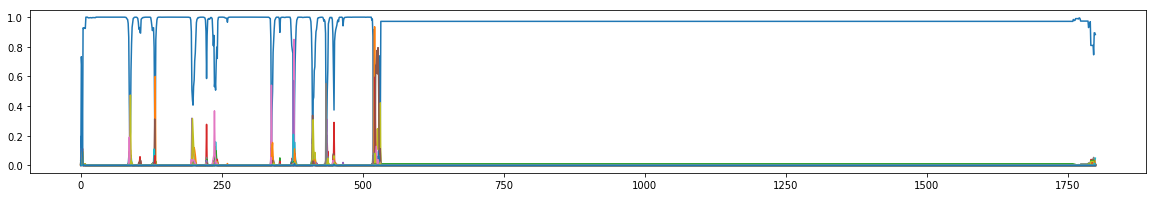

In [69]:
for (i, length) in enumerate(input_lengths):
    if length <500:
        print i
        break

checking_idx = 3
plt.figure(figsize=(20,3))
plt.plot(probs[checking_idx]);


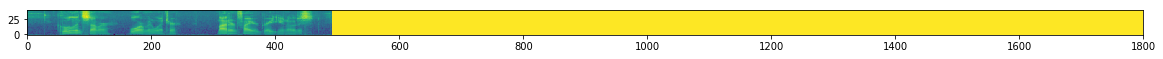

In [70]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(20,8))
mfcc_data= np.swapaxes(X[checking_idx][:,:41], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest' , origin='lower')
# plt.figure(figsize=(10,30))
# ax.set_title('MFCC')

# plt.show()

In [71]:
checking_id = short_ids[checking_idx]
checking_id

'476-133471-0010\n'

In [72]:
print [k for k in interpret_probs(probs[checking_idx], ignore_blanks=False) if True ]

[u'DH', '-', ' ', u'AO', u'R', ' ', u'L', ' ', u'AY', ' ', u'F', u'AY', ' ', u'G', ' ', u'Y', u'UW', ' ', u'B', u'EH', u'N', u'OW', u'IY', ' ', u'IY', ' ']


In [73]:
print short_phonemes[checking_idx]

[u'K', u'UW', u'L', ' ', u'IH', u'N', ' ', u'S', u'AH', u'M', u'ER', ' ', u'W', u'AO', u'R', u'M', ' ', u'IH', u'N', ' ', u'W', u'IH', u'N', u'T', u'ER', ' ', u'M', u'AA', u'D', u'ER', u'N', ' ', u'F', u'AY', u'ER', ' ', u'G', u'R', u'EY', u'T', ' ', u'Y', u'UW', ' ', u'N', u'OW', u'T', u'AH', u'S', ' ']


In [64]:
first = probs[checking_idx]
first.shape
idxs = np.argmax(first[:,:-1], axis=1)
idxs

array([36,  2,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  3,
       36,  0,  0,  0,  0, 31,  0, 36,  0,  0,  0,  0,  0,  0,  0,  6,  2,
        2, 24, 20, 20, 13,  6,  0,  6, 23,  0,  0, 16,  2, 23,  9,  0, 10,
       10,  3, 31,  3,  0,  0, 14,  2, 25, 25, 23, 23,  0,  0,  3, 23,  3,
       22,  0,  7, 28,  6,  6, 23,  0,  9, 20,  3,  0,  0,  3,  2, 31,  9,
       20,  3,  0,  0,  6, 11, 23,  0,  0, 31,  0,  3,  0,  0,  0,  0,  0,
        0,  0, 36,  0,  0,  0,  0, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2])

In [168]:
y[0]

array([32,  2, 24, 20,  0, 37, 34,  0, 15, 33,  9,  7,  6,  0, -1, -1, -1,
       -1, -1, -1], dtype=int32)

In [192]:
interpret_probs(probs[checking_idx])

NameError: name 'interpret_probs' is not defined